In [1]:
import os
import json
import glob
import math
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use({'axes.grid': False})

# Root directory where results are saved as ./model_results/{dataset}/{model}/{head}/
RESULTS_ROOT = Path("./model_results")

# Use ONLY these five foundation models (and only the backbone head)
MODELS = ["chronos_bolt", "moirai2", "timesfm", "tirex", "yinglong"]
HEADS = ["backbone", "quantiles", "gaussian", "studentst", "mixture"]
DATASETS = ["amazon-google-large", "amazon-google"]
HEAD_TO_PLOT = "backbone"

# Friendly names, colors, and markers (consistent across all plots)
MODEL_DISPLAY = {
    "chronos_bolt": "Chronos-Bolt",
    "moirai2": "MOIRAI-2",
    "timesfm": "TimesFM",
    "tirex": "TiREX",
    "yinglong": "Yinglong",
}
MODEL_COLORS = {
    "chronos_bolt": "#1b9e77",
    "moirai2": "#d95f02",
    "timesfm": "#7570b3",
    "tirex": "#e7298a",
    "yinglong": "#1f77b4",
}
MODEL_MARKERS = {
    "chronos_bolt": "o",
    "moirai2": "v",
    "timesfm": "*",
    "tirex": "P",
    "yinglong": "X",
}
HEAD_MARKERS = {
    "backbone": "o",
    "quantiles": "v",
    "gaussian": "*",
    "studentst": "P",
    "mixture": "X",
}

# Metrics we will try to use
# Canonical names used in plots: mase, pce, cce, tpce, tcce, siw, wql, msis
METRIC_SYNONYMS = {
    "mase": ["mase"],
    "pce": ["pce"],
    "tpce": ["tpce"],
    "cce": ["cce"],
    "tcce": ["tcce"],
    "siw": ["siw"],
    "wql": ["wql"],
    "msis": ["msis", "msis_80"],       # support msis_80 naming
}

# Where to write a single, indexable consolidated file for re-use
CACHE_DIR = Path("./analysis_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
CONSOLIDATED_LONG = CACHE_DIR / "consolidated_results_long.parquet"

In [ ]:
def map_metric_name(col: str) -> str:
    c = col.strip().lower()
    for canon, aliases in METRIC_SYNONYMS.items():
        if c in aliases:
            return canon
    return c

def find_first_present(cols: List[str], candidates: List[str]) -> str | None:
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        lc = cand.lower()
        if lc in cols_lower:
            return cols_lower[lc]
    return None

def load_json_safely(p: Path) -> dict:
    if not p.exists():
        return {}
    try:
        with open(p, "r") as f:
            return json.load(f)
    except Exception:
        return {}

def load_csv_safely(p: Path) -> pd.DataFrame:
    if not p.exists():
        return pd.DataFrame()
    try:
        return pd.read_csv(p)
    except Exception:
        return pd.DataFrame()

def discover_datasets(results_root: Path, models: List[str], heads: List[str]) -> List[str]:
    datasets = []
    for d in results_root.iterdir():
        if not d.is_dir():
            continue
        # Check if at least one model/head exists under this dataset
        found = False
        for m in models:
            for h in heads:
                if (d / m / h).exists():
                    found = True
                    break
            if found:
                break
        if found:
            datasets.append(d.name)
    return sorted(datasets)

def consolidate_results(
    results_root: Path, models: List[str], heads: List[str], datasets: List[str] | None = None
) -> Tuple[pd.DataFrame, Dict[str, int], Dict[Tuple[str, str], int]]:
    """
    Returns:
      - long_df: tidy DataFrame with columns:
          scope in {"series","per_h","overall"}, dataset, model, head, metric, value, series_id (opt), h (opt)
      - num_series_by_dataset: dict dataset -> max N series found across models/heads (useful for legacy column ranges)
      - num_series_by_dataset_head: dict (dataset, head) -> N series (from per_series_summary)
    """
    rows = []
    # Keep track of counts per (dataset, head)
    num_series_by_dataset_head: Dict[Tuple[str, str], int] = {}
    # Also track per-dataset max across heads/models for convenience
    num_series_by_dataset: Dict[str, int] = {}

    if datasets == None:
        datasets = discover_datasets(results_root, models, heads)
    for dataset in datasets:
        for model in models:
            for head in heads:
                base = results_root / dataset / model / head
                if not base.exists():
                    continue

                # Files we may read
                summary_json = base / "overall_summary.json"
                overall_per_h_csv = base / "overall_per_h.csv"
                per_series_sum_csv = base / "per_series_summary.csv"
                per_series_per_h_csv = base / "per_series_per_h.csv"

                # Load
                js = load_json_safely(summary_json)
                df_over_h = load_csv_safely(overall_per_h_csv)
                df_series = load_csv_safely(per_series_sum_csv)
                df_series_h = load_csv_safely(per_series_per_h_csv)  # currently unused in plotting

                # Per-series metrics (scope=series)
                if not df_series.empty:
                    series_id_col = find_first_present(df_series.columns.tolist(), ["unique_id", "series_id", "series"])
                    value_cols = [c for c in df_series.columns if c not in {series_id_col, "dataset", "model", "head"}]
                    df_s = df_series.copy()
                    if series_id_col is None:
                        df_s["_series_id"] = np.arange(len(df_s)) + 1
                        series_id_col = "_series_id"
                    # Standardize metric names
                    rename_map = {c: map_metric_name(c) for c in value_cols}
                    df_s = df_s.rename(columns=rename_map)
                    keep_cols = [series_id_col] + list(set(rename_map.values()))
                    df_s = df_s[keep_cols]

                    # Melt to long
                    s_long = df_s.melt(
                        id_vars=[series_id_col],
                        var_name="metric",
                        value_name="value",
                    ).dropna(subset=["value"])
                    for _, r in s_long.iterrows():
                        rows.append({
                            "scope": "series",
                            "dataset": dataset,
                            "model": model,
                            "head": head,
                            "metric": r["metric"],
                            "value": r["value"],
                            "series_id": str(r[series_id_col]),
                            "h": np.nan,
                        })
                    # Save counts
                    n_ser = int(df_s[series_id_col].nunique())
                    num_series_by_dataset_head[(dataset, head)] = max(
                        n_ser, num_series_by_dataset_head.get((dataset, head), 0)
                    )
                    num_series_by_dataset[dataset] = max(
                        n_ser, num_series_by_dataset.get(dataset, 0)
                    )
                else:
                    # If no per-series file, leave counts unchanged
                    pass

                # Per-horizon overall metrics (scope=per_h)
                if not df_over_h.empty:
                    cols = df_over_h.columns.tolist()
                    h_col = find_first_present(cols, ["h", "H", "horizon"])
                    if h_col is None:
                        h_col = "h"
                        df_over_h = df_over_h.rename(columns={cols[0]: "h"})
                    metric_cols = [c for c in df_over_h.columns if c != h_col]
                    rename_map = {c: map_metric_name(c) for c in metric_cols}
                    df_h = df_over_h.rename(columns=rename_map)
                    for mc in set(rename_map.values()):
                        if mc in df_h.columns:
                            for _, r in df_h[[h_col, mc]].dropna().iterrows():
                                rows.append({
                                    "scope": "per_h",
                                    "dataset": dataset,
                                    "model": model,
                                    "head": head,
                                    "metric": mc,
                                    "value": r[mc],
                                    "series_id": "",
                                    "h": int(r[h_col]),
                                })

                # Overall single numbers (scope=overall) from JSON if present
                def add_overall(metric_key: str, value: float | None):
                    if value is None or pd.isna(value):
                        return
                    rows.append({
                        "scope": "overall",
                        "dataset": dataset,
                        "model": model,
                        "head": head,
                        "metric": metric_key,
                        "value": float(value),
                        "series_id": "",
                        "h": np.nan,
                    })

                if isinstance(js, dict) and js:
                    lower = {k.lower(): v for k, v in js.items()}
                    for canon in ["mase", "pce", "cce", "tcce", "tpce", "siw", "wql", "msis", "msis_80"]:
                        obj = lower.get(canon, lower.get(canon.upper(), None))
                        if isinstance(obj, dict):
                            cand = None
                            for k2 in ["mean_over_h", "overall", "avg", "mean"]:
                                if k2 in obj and obj[k2] is not None:
                                    cand = obj[k2]
                                    break
                            if cand is not None:
                                add_overall(map_metric_name(canon), float(cand))
                        elif isinstance(obj, (int, float)):
                            add_overall(map_metric_name(canon), float(obj))

    long_df = pd.DataFrame(rows)
    if not long_df.empty:
        long_df["metric"] = long_df["metric"].astype(str)
        long_df["metric"] = long_df["metric"].map(map_metric_name)

    return long_df, num_series_by_dataset, num_series_by_dataset_head

# Helper: get display name, color, marker
def disp(model: str) -> str:
    return MODEL_DISPLAY.get(model, model)

def mcolor(model: str) -> str:
    return MODEL_COLORS.get(model, "#333333")

def mmarker(model: str) -> str:
    return MODEL_MARKERS.get(model, "o")

def hmarker(head: str) -> str:
    return HEAD_MARKERS.get(head, "o")

# General utility: dynamic subplot grid for N items (tries to be close to square)
def best_grid(n: int, max_cols: int = 3) -> Tuple[int, int]:
    if n <= 0:
        return 1, 1
    cols = min(max_cols, max(1, int(math.ceil(math.sqrt(n)))))
    rows = int(math.ceil(n / cols))
    return rows, cols

# If overall_df is empty, create dataset-level "overall" by aggregating series metrics (median)
def ensure_overall(overall_df: pd.DataFrame, series_df: pd.DataFrame) -> pd.DataFrame:
    if not overall_df.empty:
        return overall_df
    if series_df.empty:
        return overall_df
    agg = (
        series_df
        .groupby(["dataset", "model", "metric"], as_index=False)["value"]
        .median()
        .rename(columns={"value": "value"})
    )
    agg["scope"] = "overall"
    agg["series_id"] = ""
    agg["h"] = np.nan
    return agg

# Compare Backbones

In [ ]:
long_df, num_timeseries, num_timeseries_by_dataset_head = consolidate_results(RESULTS_ROOT, MODELS, HEADS, DATASETS)

# Filter to a single head for all downstream plots
if not long_df.empty:
    long_df = long_df[long_df["head"] == HEAD_TO_PLOT]

# Keep only the selected models that were actually found
present_models = sorted(long_df["model"].unique().tolist()) if not long_df.empty else []
present_models = [m for m in MODELS if m in present_models]
datasets = sorted(long_df["dataset"].unique().tolist()) if not long_df.empty else []

print("Datasets discovered:", datasets)
print("Models discovered:  ", present_models)
print("Num time series per dataset:", num_timeseries)

# Save the single indexable file for re-use
if not long_df.empty:
    long_df.to_parquet(CONSOLIDATED_LONG, index=False)
    print(f"Wrote consolidated long results to {CONSOLIDATED_LONG.resolve()}")
else:
    print("No data found. Check RESULTS_ROOT and HEAD name.")

# Convenience slices
series_df = long_df[long_df["scope"] == "series"].copy()
per_h_df = long_df[long_df["scope"] == "per_h"].copy()
overall_df = long_df[long_df["scope"] == "overall"].copy()

overall_df = ensure_overall(overall_df, series_df)

Datasets discovered: ['amazon-google', 'amazon-google-large']
Models discovered:   ['chronos_bolt', 'moirai2', 'timesfm', 'tirex', 'yinglong']
Num time series per dataset: {'amazon-google-large': 235, 'amazon-google': 20}
Wrote consolidated long results to /extra/datalab_scratch0/ctadler/time_series_models/tsfm_head_calibration/analysis_cache/consolidated_results_long.parquet


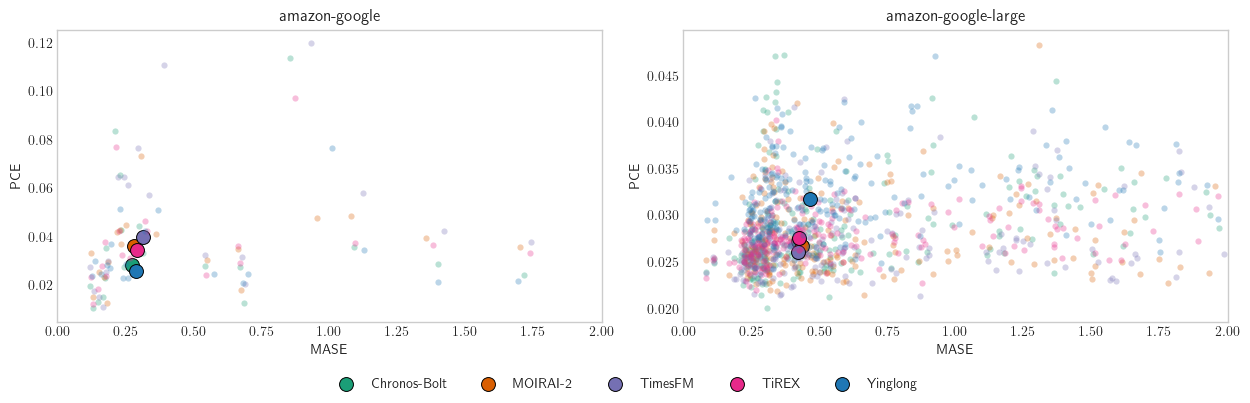

In [5]:
# Figure 1: MASE vs PCE (scatter) per dataset (backbone only)
metrics_pair = ("mase", "pce")

# Prepare datasets grid
n = len(datasets)
rows, cols = best_grid(n, max_cols=2)
scale = 0.9
fig, axes = plt.subplots(rows, cols, figsize=(7*scale*cols, 4.5*scale*rows), squeeze=False)

for idx, dataset in enumerate(datasets):
    ax = axes[idx // cols][idx % cols]
    # Plot each model
    for model in present_models:
        # per-series points
        xs = series_df.query("dataset == @dataset and model == @model and metric == @metrics_pair[0]")["value"]
        ys = series_df.query("dataset == @dataset and model == @model and metric == @metrics_pair[1]")["value"]

        # Align series by series_id if present
        if not series_df.empty:
            sx = series_df.query("dataset == @dataset and model == @model and metric == @metrics_pair[0]")[["series_id","value"]]
            sy = series_df.query("dataset == @dataset and model == @model and metric == @metrics_pair[1]")[["series_id","value"]]
            merged = sx.merge(sy, on="series_id", suffixes=("_x", "_y"))
            xs = merged["value_x"].to_numpy()
            ys = merged["value_y"].to_numpy()

        ax.scatter(xs, ys, c=mcolor(model), alpha=0.3, marker=hmarker(HEAD_TO_PLOT), s=20, linewidths=0, label=None)

        # Large dot: median of series values
        if len(xs) > 0 and len(ys) > 0:
            ax.scatter(np.median(xs), np.median(ys), c=mcolor(model), s=100, edgecolors='black',
                       alpha=1, marker=hmarker(HEAD_TO_PLOT), linewidths=0.7, label=disp(model))

    ax.set_title(dataset)
    ax.set_xlabel("MASE")
    ax.set_ylabel("PCE")
    ax.set_xlim(0,2)

# Shared legend
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncols=len(present_models), framealpha=0)
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()

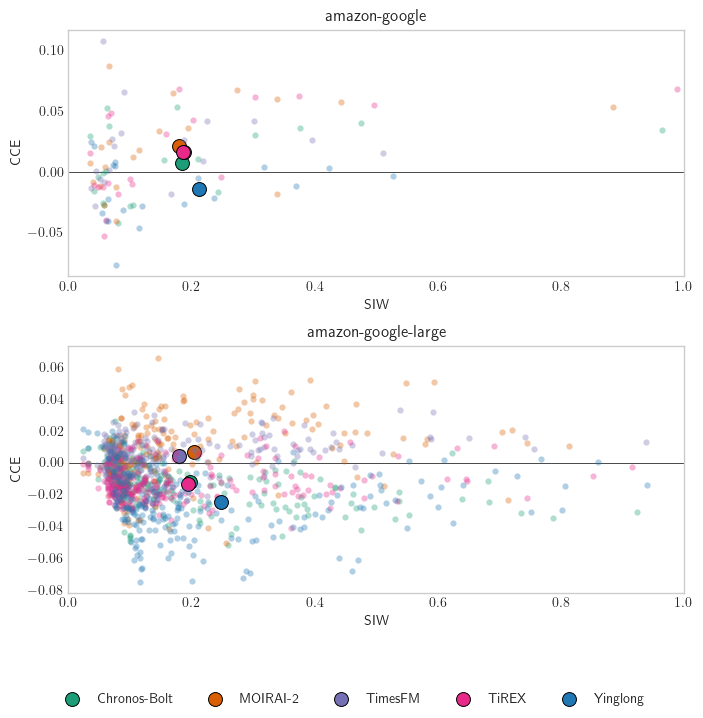

In [6]:
# Figure 2: SIW vs CCE (scatter) per dataset with y=0 line
metrics_pair = ("siw", "cce")

n = len(datasets)
rows, cols = best_grid(n, max_cols=2)
scale = 0.9
fig, axes = plt.subplots(cols, rows, figsize=(4*scale*cols, 4*scale*rows*len(DATASETS)))
# normalize axes to 2D array regardless of shape
axes = np.array(axes).reshape(rows, cols)

for idx, dataset in enumerate(datasets):
    ax = axes[idx // cols][idx % cols]
    ax.axhline(0, c='black', lw=0.5, zorder=0)
    for model in present_models:
        sx = series_df.query("dataset == @dataset and model == @model and metric == @metrics_pair[0]")[["series_id","value"]]
        sy = series_df.query("dataset == @dataset and model == @model and metric == @metrics_pair[1]")[["series_id","value"]]
        merged = sx.merge(sy, on="series_id", suffixes=("_x", "_y"))
        xs = merged["value_x"].to_numpy()
        ys = merged["value_y"].to_numpy()
        ax.scatter(xs, ys, c=mcolor(model), alpha=0.35, marker=hmarker(HEAD_TO_PLOT), s=20, linewidths=0)

        if len(xs) > 0 and len(ys) > 0:
            ax.scatter(np.mean(xs), np.mean(ys), c=mcolor(model), s=100, edgecolors='black',
                       alpha=1, marker=hmarker(HEAD_TO_PLOT), linewidths=0.7, label=disp(model))

    ax.set_title(dataset)
    ax.set_xlabel("SIW")
    ax.set_ylabel("CCE")
    ax.set_xlim(0,1)

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncols=len(present_models), framealpha=0)
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

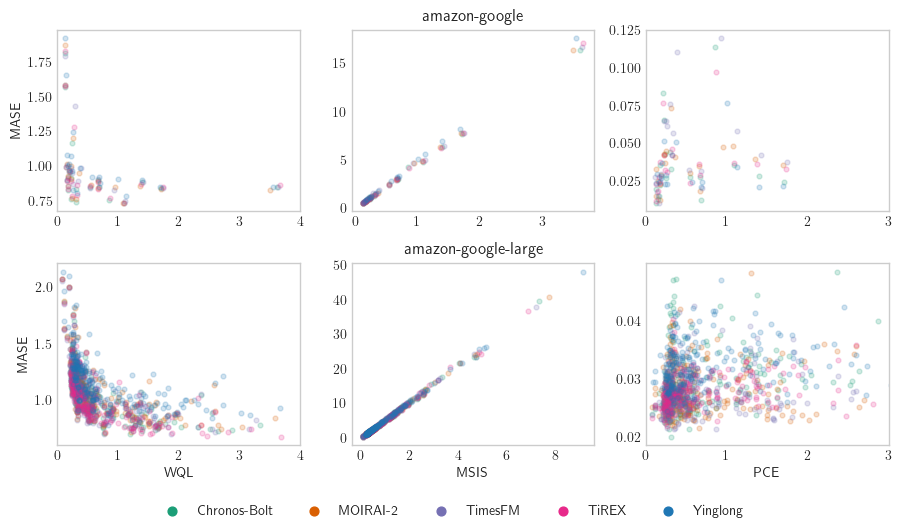

In [7]:
# Figure 3: WQL, MSIS, PCE vs MASE (per-series scatter), shape [n_datasets, 3]

x_metric = "mase"
y_metrics = ["wql", "msis", "pce"]
y_names = ["WQL", "MSIS", "PCE"]

rows = len(datasets)
cols = len(y_metrics)
scale = 0.95
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols*scale, 2.8*rows*scale), squeeze=False)

for i, dataset in enumerate(datasets):
    for j, (ym, yname) in enumerate(zip(y_metrics, y_names)):
        ax = axes[i][j]
        for model in present_models:
            sx = series_df.query("dataset == @dataset and model == @model and metric == @x_metric")[["series_id","value"]]
            sy = series_df.query("dataset == @dataset and model == @model and metric == @ym")[["series_id","value"]]
            merged = sx.merge(sy, on="series_id", suffixes=("_x", "_y"))
            ax.scatter(merged["value_x"], merged["value_y"], s=12, c=mcolor(model), marker=hmarker(HEAD_TO_PLOT), alpha=0.2)
            ax.scatter([], [], label=disp(model), s=40, c=mcolor(model), marker=hmarker(HEAD_TO_PLOT))
        if j == 0:
            ax.set_ylabel("MASE")
        if i == rows - 1:
            ax.set_xlabel(yname)
        if j == 1:
            ax.set_title(dataset)
        if yname == 'PCE':
            ax.set_xlim(0,3)
        if yname == 'WQL':
            ax.set_xlim(0,4)

handles, labels = axes[0][0].get_legend_handles_labels()
plt.tight_layout(rect=[0, 0.06, 1, 1])
fig.legend(handles, labels, loc="lower center", ncols=len(present_models), framealpha=1)
plt.show()

/tmp/ipykernel_1730334/3861524755.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.09, 1, 1])


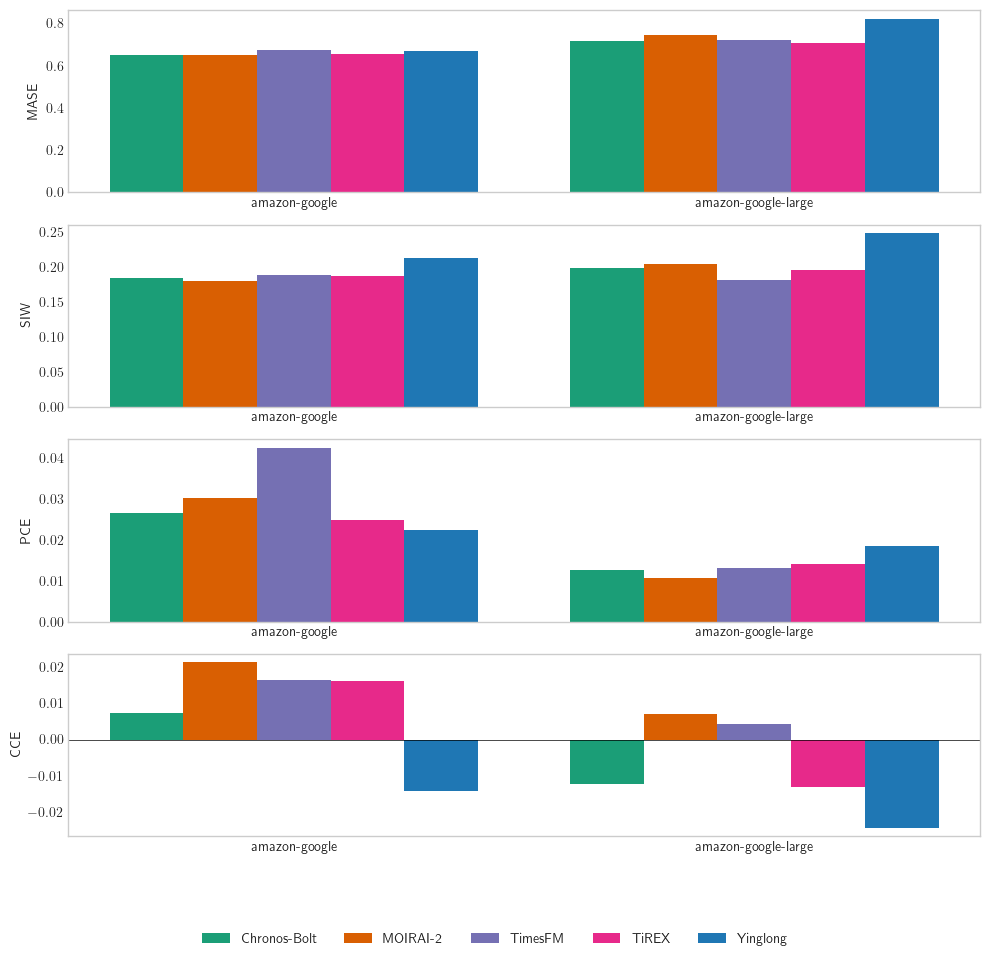

In [8]:
# Figure 4: Grouped bars by dataset (x) and model (bars) for [MASE, SIW, PCE, CCE]
bar_metrics = ["mase", "siw", "pce", "cce"]
bar_names = ["MASE", "SIW", "PCE", "CCE"]

rows = len(bar_metrics)
fig, axes = plt.subplots(rows, 1, figsize=(10, 2.4*rows), layout="constrained")

x = np.arange(len(datasets))
width = 0.8 / max(1, len(present_models))

for i, (bm, bname) in enumerate(zip(bar_metrics, bar_names)):
    ax = axes[i] if rows > 1 else axes
    # Build values per model
    for k, model in enumerate(present_models):
        vals = []
        for dataset in datasets:
            val = overall_df.query("dataset == @dataset and model == @model and metric == @bm")["value"]
            # If no 'overall' row, try fallback as median over series:
            if val.empty:
                tmp = (series_df.query("dataset == @dataset and model == @model and metric == @bm")["value"])
                val = pd.Series([tmp.median() if not tmp.empty else np.nan])
            vals.append(float(val.iloc[0]) if not val.empty else np.nan)
        offset = (k - (len(present_models)-1)/2) * width
        ax.bar(x + offset, vals, width, label=disp(model), color=mcolor(model))

    if bm in {"cce", "tcce"}:
        ax.axhline(0, c='black', lw=0.5)
    ax.set_ylabel(bname)
    ax.set_xticks(x, datasets)

handles, labels = axes[-1].get_legend_handles_labels() if rows > 1 else axes.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncols=len(present_models), framealpha=1)
plt.tight_layout(rect=[0, 0.09, 1, 1])
plt.show()

/tmp/ipykernel_1730334/4195245558.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.09, 1, 1])


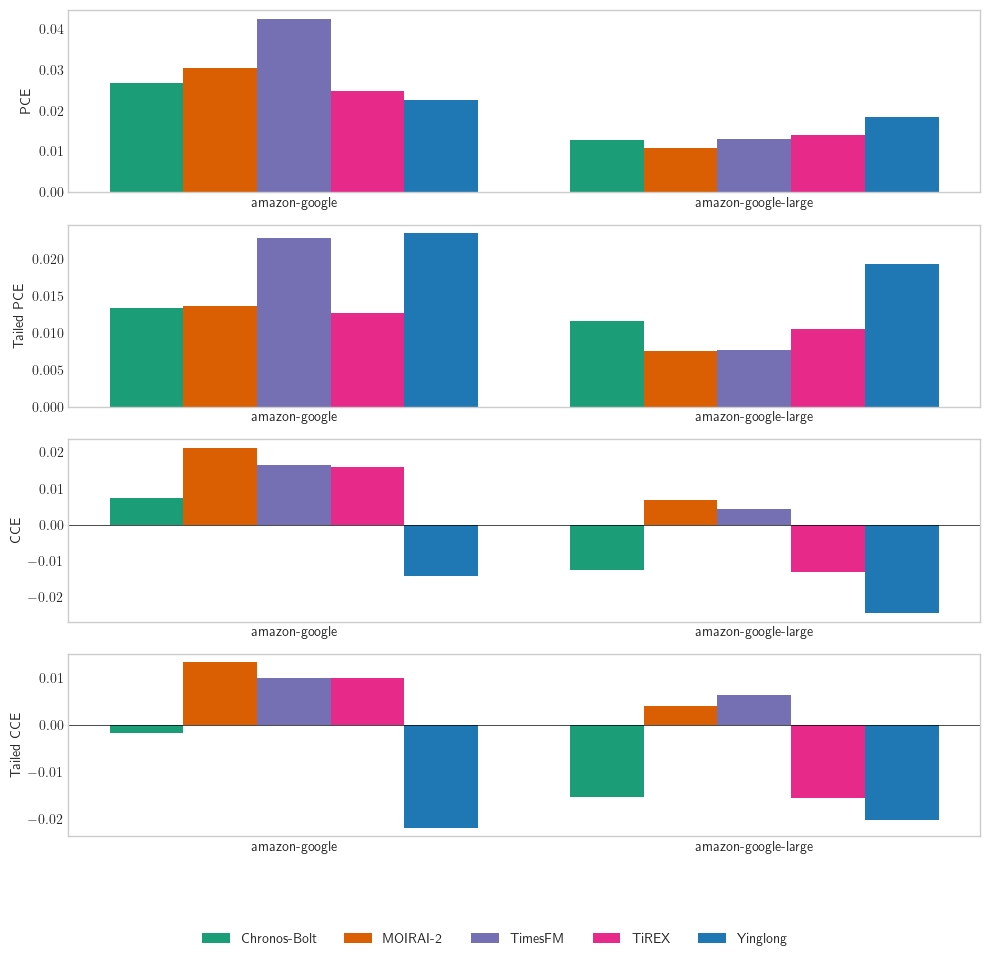

In [9]:
# Figure 5: Grouped bars for [PCE, TPCE, CCE, TCCE]
bar_metrics = ["pce", "tpce", "cce", "tcce"]
bar_names = ["PCE", "Tailed PCE", "CCE", "Tailed CCE"]

rows = len(bar_metrics)
fig, axes = plt.subplots(rows, 1, figsize=(10, 2.4*rows), layout="constrained")

x = np.arange(len(datasets))
width = 0.8 / max(1, len(present_models))

for i, (bm, bname) in enumerate(zip(bar_metrics, bar_names)):
    ax = axes[i] if rows > 1 else axes
    for k, model in enumerate(present_models):
        vals = []
        for dataset in datasets:
            val = overall_df.query("dataset == @dataset and model == @model and metric == @bm")["value"]
            if val.empty:
                tmp = (series_df.query("dataset == @dataset and model == @model and metric == @bm")["value"])
                val = pd.Series([tmp.median() if not tmp.empty else np.nan])
            vals.append(float(val.iloc[0]) if not val.empty else np.nan)
        offset = (k - (len(present_models)-1)/2) * width
        ax.bar(x + offset, vals, width, label=disp(model), color=mcolor(model))
    if bm in {"cce", "tcce"}:
        ax.axhline(0, c='black', lw=0.5)
    ax.set_ylabel(bname)
    ax.set_xticks(x, datasets)

handles, labels = axes[-1].get_legend_handles_labels() if rows > 1 else axes.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncols=len(present_models), framealpha=1)
plt.tight_layout(rect=[0, 0.09, 1, 1])
plt.show()

/tmp/ipykernel_1730334/2037023850.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.09, 1, 1])


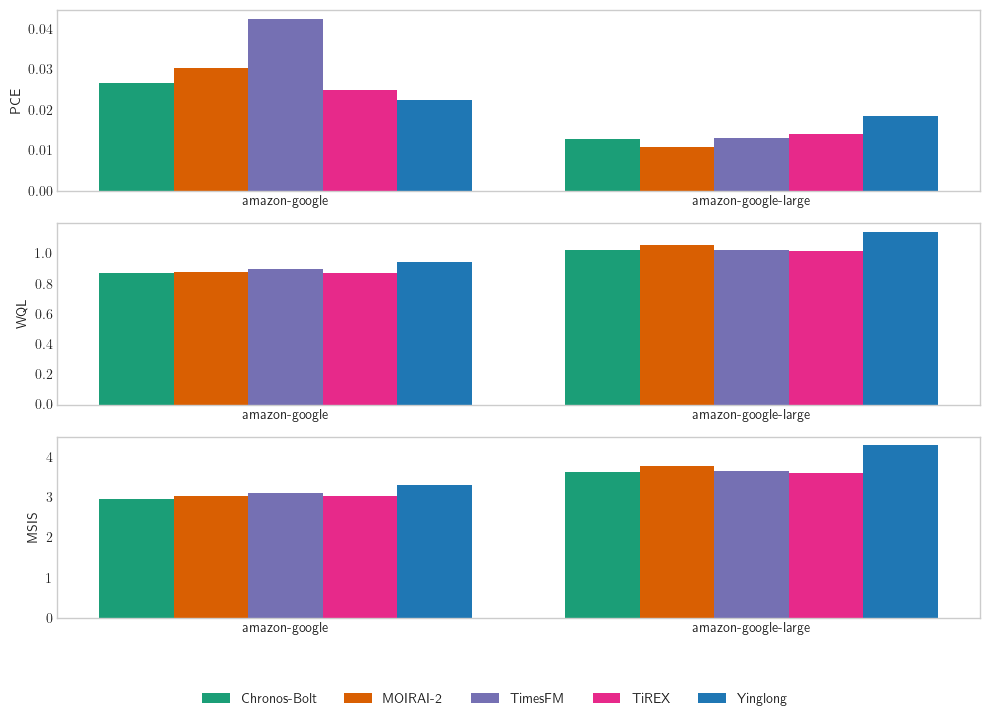

In [10]:
# Figure 6: Grouped bars for [PCE, WQL, MSIS]
bar_metrics = ["pce", "wql", "msis"]
bar_names = ["PCE", "WQL", "MSIS"]

rows = len(bar_metrics)
fig, axes = plt.subplots(rows, 1, figsize=(10, 2.4*rows), layout="constrained")

x = np.arange(len(datasets))
width = 0.8 / max(1, len(present_models))

for i, (bm, bname) in enumerate(zip(bar_metrics, bar_names)):
    ax = axes[i] if rows > 1 else axes
    for k, model in enumerate(present_models):
        vals = []
        for dataset in datasets:
            val = overall_df.query("dataset == @dataset and model == @model and metric == @bm")["value"]
            if val.empty:
                tmp = (series_df.query("dataset == @dataset and model == @model and metric == @bm")["value"])
                val = pd.Series([tmp.median() if not tmp.empty else np.nan])
            vals.append(float(val.iloc[0]) if not val.empty else np.nan)
        offset = (k - (len(present_models)-1)/2) * width
        ax.bar(x + offset, vals, width, label=disp(model), color=mcolor(model))
    ax.set_ylabel(bname)
    ax.set_xticks(x, datasets)

handles, labels = axes[-1].get_legend_handles_labels() if rows > 1 else axes.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncols=len(present_models), framealpha=1)
plt.tight_layout(rect=[0, 0.09, 1, 1])
plt.show()

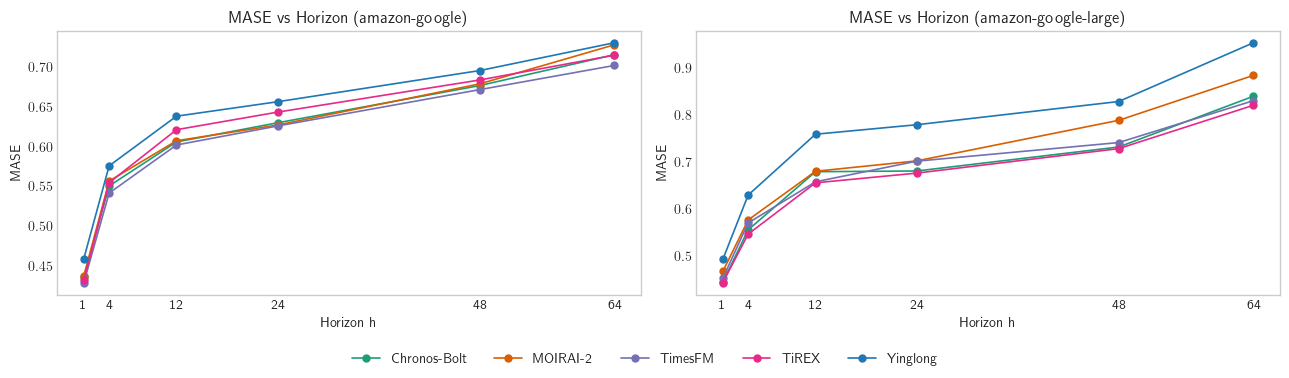

In [11]:
# Figure 7: MASE across forecast horizon (lines) per dataset
metric = "mase"
# Horizons to plot
PRED_HORIZONS = [1, 4, 12, 24, 48, 64]

rows, cols = best_grid(len(datasets), max_cols=2)
fig, axes = plt.subplots(rows, cols, figsize=(6.5*cols, 3.8*rows), squeeze=False)

for idx, dataset in enumerate(datasets):
    ax = axes[idx // cols][idx % cols]
    dsub = per_h_df.query("dataset == @dataset and metric == @metric")
    for model in present_models:
        y = (
            dsub.query("model == @model")
                .set_index("h")
                .sort_index()
                .reindex(PRED_HORIZONS)  # keep only chosen horizons (NaNs where missing)
        )
        if y["value"].notna().sum() == 0:
            continue
        ax.plot(PRED_HORIZONS, y["value"], label=disp(model), marker=hmarker(HEAD_TO_PLOT),
                lw=1.2, c=mcolor(model), markersize=5)
    ax.set_title(f"MASE vs Horizon ({dataset})")
    ax.set_xlabel("Horizon h")
    ax.set_ylabel("MASE")
    ax.set_xticks(PRED_HORIZONS, [str(h) for h in PRED_HORIZONS])

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncols=len(present_models), framealpha=1)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

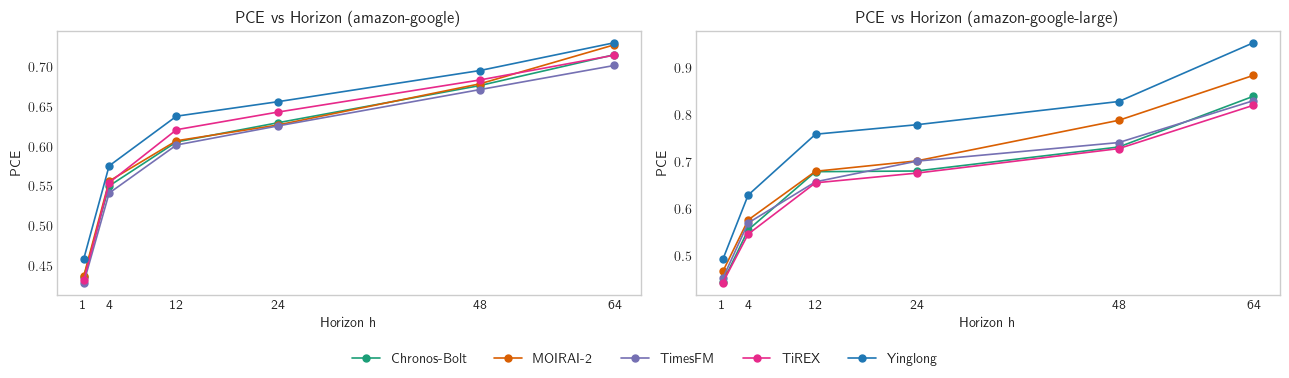

In [12]:
# Figure 8: PCE across forecast horizon (lines) per datasetmetric = "pce"
PRED_HORIZONS = [1, 4, 12, 24, 48, 64]

rows, cols = best_grid(len(datasets), max_cols=2)
fig, axes = plt.subplots(rows, cols, figsize=(6.5*cols, 3.8*rows), squeeze=False)

for idx, dataset in enumerate(datasets):
    ax = axes[idx // cols][idx % cols]
    dsub = per_h_df.query("dataset == @dataset and metric == @metric")
    for model in present_models:
        y = (
            dsub.query("model == @model")
               .set_index("h")
               .sort_index()
               .reindex(PRED_HORIZONS)
        )
        if y["value"].notna().sum() == 0:
            continue
        ax.plot(PRED_HORIZONS, y["value"], label=disp(model), marker=hmarker(HEAD_TO_PLOT),
                lw=1.2, c=mcolor(model), markersize=5)
    ax.set_title(f"PCE vs Horizon ({dataset})")
    ax.set_xlabel("Horizon h")
    ax.set_ylabel("PCE")
    ax.set_xticks(PRED_HORIZONS, [str(h) for h in PRED_HORIZONS])

handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncols=len(present_models), framealpha=1)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

# Comparing Heads

In [18]:
long_df, num_timeseries, num_timeseries_by_dataset_head = consolidate_results(RESULTS_ROOT, MODELS, HEADS, DATASETS)

series_df = long_df[long_df["scope"] == "series"].copy()
per_h_df = long_df[long_df["scope"] == "per_h"].copy()
overall_df = long_df[long_df["scope"] == "overall"].copy()

overall_df = ensure_overall(overall_df, series_df)

# Present entities from the unfiltered long_df
present_models = [m for m in MODELS if m in set(long_df["model"].unique())]
datasets = sorted(long_df["dataset"].unique())
present_heads = [h for h in HEADS if h in set(long_df["head"].unique())]

print("Models:", present_models)
print("Datasets:", datasets)
print("Heads:", present_heads)

# Build a wide "overall" pivot: one row per (dataset, model, head), columns=metrics
# Assumes you already ran: overall_df = ensure_overall(overall_df, series_df)
overall_wide = (
    overall_df
    .pivot_table(index=["dataset","model","head"], columns="metric", values="value", aggfunc="mean")
    .reset_index()
)
# Make metric columns lower-case for safety (canonicalized earlier)
overall_wide.columns = [c.lower() if isinstance(c, str) else c for c in overall_wide.columns]

# Helper: consistent color for models (use your existing mcolor(model) if available)
try:
    _ = mcolor  # if user already defined
except NameError:
    import matplotlib as mpl
    cmap = mpl.cm.get_cmap("tab10")
    model_palette = {m: cmap(i % 10) for i, m in enumerate(present_models)}
    def mcolor(model: str): return model_palette.get(model, "gray")

# Helper: display label for models (use disp if you have), fallback to identity
try:
    _ = disp
except NameError:
    def disp(x): return x

Models: ['chronos_bolt', 'moirai2', 'timesfm', 'tirex', 'yinglong']
Datasets: ['amazon-google', 'amazon-google-large']
Heads: ['backbone', 'quantiles', 'gaussian', 'studentst', 'mixture']


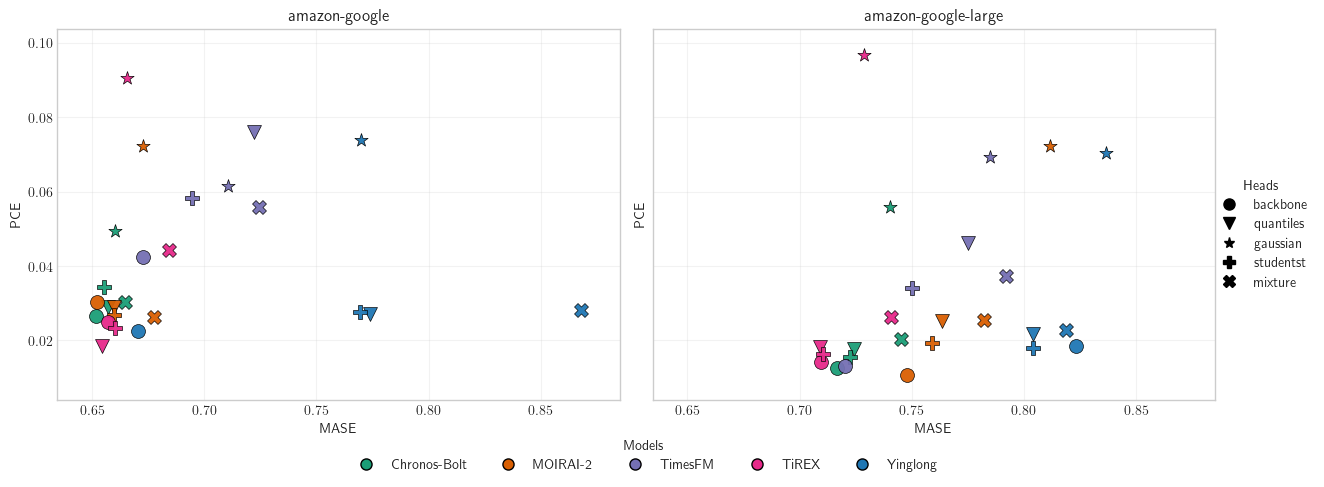

In [20]:
# Figure 9 Subplot of scatters (PCE vs MASE),
# Collect global limits to share across subplots
pts = overall_wide.dropna(subset=["mase", "pce"])
if pts.empty:
    print("No overall MASE/PCE found; cannot plot Figure 9.")
else:
    xvals = pts["mase"].values
    yvals = pts["pce"].values
    # Add small margins
    def with_margin(arr, frac=0.05):
        lo, hi = np.nanmin(arr), np.nanmax(arr)
        span = max(hi - lo, 1e-9)
        return lo - frac*span, hi + frac*span
    xlim = with_margin(xvals, 0.08)
    ylim = with_margin(yvals, 0.08)

    rows = int(np.ceil(len(datasets) / 2))
    cols = min(2, len(datasets)) if len(datasets) > 0 else 1
    fig, axes = plt.subplots(rows, cols, figsize=(6.5*cols, 4.8*rows), squeeze=False, sharex=True, sharey=True)

    for idx, dataset in enumerate(datasets):
        ax = axes[idx // cols][idx % cols]
        dsub = overall_wide[overall_wide["dataset"] == dataset]
        # Plot each model×head point
        for model in present_models:
            msub = dsub[dsub["model"] == model]
            for head in present_heads:
                r = msub[msub["head"] == head]
                if r.empty or r[["mase","pce"]].isna().any(axis=None):
                    print(f"Missing head: {head} MASE or PCE")
                    continue
                ax.scatter(
                    r["mase"].values[0], r["pce"].values[0],
                    c=[mcolor(model)], marker=hmarker(head), s=100, alpha=0.95, edgecolor="black", linewidths=0.5
                )
        ax.set_title(f"{dataset}")
        ax.set_xlabel("MASE")
        ax.set_ylabel("PCE")
        ax.grid(True, alpha=0.25)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

    # Legends: one for models (colors), one for heads (markers)
    from matplotlib.lines import Line2D
    model_handles = [Line2D([0],[0], marker='o', color='none', markerfacecolor=mcolor(m), markeredgecolor='black',
                            markersize=8, label=disp(m)) for m in present_models]
    head_handles = [Line2D([0],[0], marker=hmarker(h), color='black', linestyle='None', label=h, markersize=8) for h in present_heads]

    # Put legends below and right
    # First put model legend centered below
    leg1 = fig.legend(handles=model_handles, title="Models", loc="lower center",
                      ncols=min(len(model_handles), 6), bbox_to_anchor=(0.5, -0.02), framealpha=1)
    # Then put head legend to the right
    leg2 = fig.legend(handles=head_handles, title="Heads", loc="center right",
                      bbox_to_anchor=(1.02, 0.5), framealpha=1)

    plt.tight_layout(rect=[0, 0.05, 0.95, 1])
    plt.show()

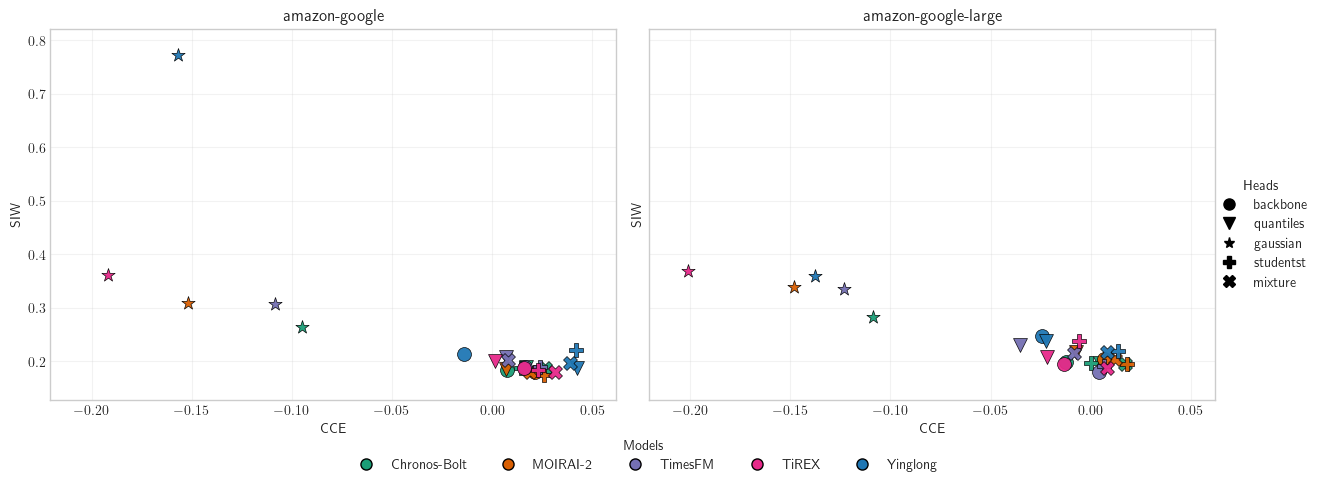

In [22]:
# Figure 10 Subplots of scatters (CCE vs SIW)
needed = {"cce", "siw"}
missing = [m for m in needed if m not in overall_wide.columns]
if missing:
    print(f"Skipping Figure 10: missing metrics {missing}")
else:
    pts = overall_wide.dropna(subset=["cce", "siw"])
    if pts.empty:
        print("No overall CCE/SIW found; cannot plot Figure 10.")
    else:
        xvals = pts["cce"].values
        yvals = pts["siw"].values
        def with_margin(arr, frac=0.05):
            lo, hi = np.nanmin(arr), np.nanmax(arr)
            span = max(hi - lo, 1e-9)
            return lo - frac*span, hi + frac*span
        xlim = with_margin(xvals, 0.08)
        ylim = with_margin(yvals, 0.08)

        rows = int(np.ceil(len(datasets) / 2))
        cols = min(2, len(datasets)) if len(datasets) > 0 else 1
        fig, axes = plt.subplots(rows, cols, figsize=(6.5*cols, 4.8*rows), squeeze=False, sharex=True, sharey=True)

        for idx, dataset in enumerate(datasets):
            ax = axes[idx // cols][idx % cols]
            dsub = overall_wide[overall_wide["dataset"] == dataset]
            for model in present_models:
                msub = dsub[dsub["model"] == model]
                for head in present_heads:
                    r = msub[msub["head"] == head]
                    if r.empty or r[["cce","siw"]].isna().any(axis=None):
                        continue
                    ax.scatter(
                        r["cce"].values[0], r["siw"].values[0],
                        c=[mcolor(model)], marker=hmarker(head), s=100, alpha=0.95, edgecolor="black", linewidths=0.5
                    )
            ax.set_title(f"{dataset}")
            ax.set_xlabel("CCE")
            ax.set_ylabel("SIW")
            ax.grid(True, alpha=0.25)
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)

        from matplotlib.lines import Line2D
        model_handles = [Line2D([0],[0], marker='o', color='none', markerfacecolor=mcolor(m), markeredgecolor='black',
                                markersize=8, label=disp(m)) for m in present_models]
        head_handles = [Line2D([0],[0], marker=hmarker(h), color='black', linestyle='None', label=h, markersize=8) for h in present_heads]
        leg1 = fig.legend(handles=model_handles, title="Models", loc="lower center",
                          ncols=min(len(model_handles), 6), bbox_to_anchor=(0.5, -0.02), framealpha=1)
        leg2 = fig.legend(handles=head_handles, title="Heads", loc="center right",
                          bbox_to_anchor=(1.02, 0.5), framealpha=1)

        plt.tight_layout(rect=[0, 0.05, 0.95, 1])
        plt.show()

/tmp/ipykernel_1730334/2428127564.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  head_cmap = mpl.cm.get_cmap("Set2", max(len(present_heads), 3))


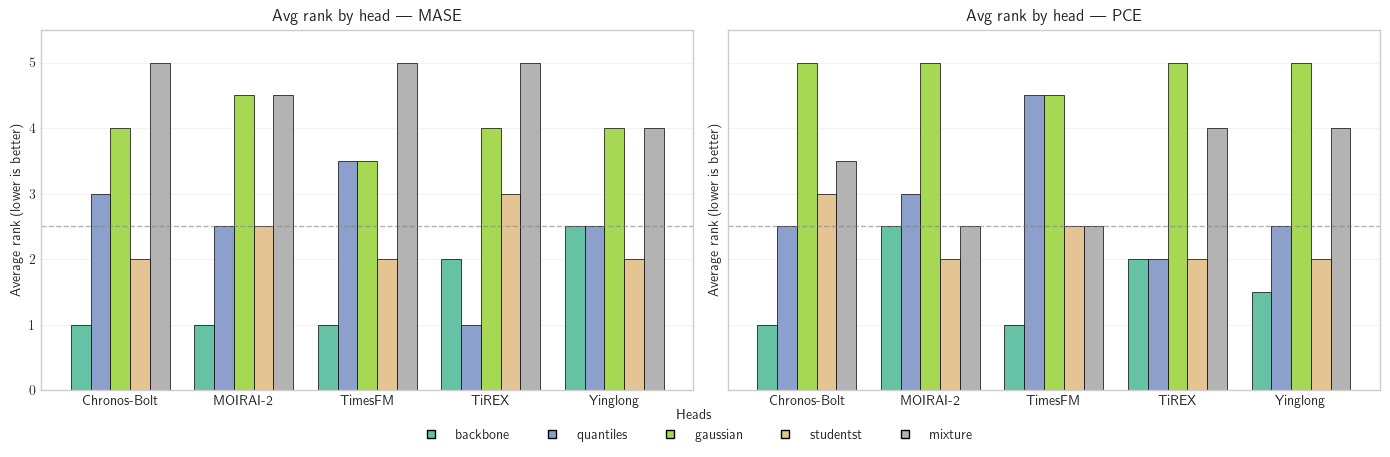

In [30]:
def compute_avg_relative_rank(df_wide: pd.DataFrame, metric: str) -> pd.DataFrame:
    if metric not in df_wide.columns:
        return pd.DataFrame(columns=["model","head","avg_rel_rank"])

    # Keep only rows with finite metric
    z = df_wide[~df_wide[metric].isna()].copy()
    if z.empty:
        return pd.DataFrame(columns=["model","head","avg_rel_rank"])

    # Rank per (dataset, model) across heads
    def rank_block(block: pd.DataFrame):
        n = len(block)
        if n <= 1:
            block["_rel_rank"] = 0.0
            return block
        # Smaller is better
        block["_rank"] = block[metric].rank(ascending=True, method="average")
        block["_rel_rank"] = (block["_rank"])
        return block

    ranked = (
        z
        .groupby(["dataset","model"], group_keys=False)
        .apply(rank_block)
    )

    # Average across datasets (over available heads per model)
    avg_rr = (
        ranked
        .groupby(["model","head"], as_index=False)["_rel_rank"]
        .mean()
        .rename(columns={"_rel_rank": "avg_rel_rank"})
    )
    return avg_rr

metrics_for_bars = ["mase", "pce"]
bar_data = {m: compute_avg_relative_rank(overall_wide, m) for m in metrics_for_bars}

# Colors for heads in bar charts (distinct from model colors to highlight heads)
import matplotlib as mpl
head_cmap = mpl.cm.get_cmap("Set2", max(len(present_heads), 3))
head_color = {h: head_cmap(i % head_cmap.N) for i, h in enumerate(present_heads)}

# Build plots
rows, cols = 1, 2
fig, axes = plt.subplots(rows, cols, figsize=(7.0*cols, 4.5*rows), squeeze=False, sharey=True)

for j, metric in enumerate(metrics_for_bars):
    ax = axes[0][j]
    dfm = bar_data[metric]
    if dfm.empty:
        ax.set_title(f"{metric.upper()}: no data")
        ax.axis("off")
        continue

    # Ensure every model-head appears even if missing (fill with NaN -> skip, or 0.5 baseline?)
    # We'll merge into a full grid and leave NaN; bars will be skipped. Alternatively, fill with 0.5.
    full = (
        pd.MultiIndex.from_product([present_models, present_heads], names=["model","head"])
        .to_frame(index=False)
        .merge(dfm, on=["model","head"], how="left")
    )

    # Grouped bar positions
    models_order = present_models
    heads_order = present_heads
    group_width = 0.8
    n_heads = len(heads_order)
    bar_width = group_width / max(n_heads, 1)
    x = np.arange(len(models_order))

    for i, head in enumerate(heads_order):
        y = []
        for model in models_order:
            row = full[(full["model"] == model) & (full["head"] == head)]
            val = row["avg_rel_rank"].values[0] if len(row) == 1 else np.nan
            y.append(val)
        # Mask NaNs to avoid warnings; plot only finite bars
        y = np.array(y, dtype=float)
        # Positions for this head inside each model group
        xi = x - group_width/2 + i*bar_width + bar_width/2
        ax.bar(xi[~np.isnan(y)], y[~np.isnan(y)], width=bar_width, color=head_color[head], label=head, edgecolor="black", linewidth=0.5)

    ax.set_title(f"Avg rank by head — {metric.upper()}")
    ax.set_ylabel("Average rank (lower is better)")
    ax.set_xticks(x, [disp(m) for m in models_order], rotation=0)
    ax.set_ylim(0, 5+0.5)
    ax.axhline(len(HEADS)/2, color="gray", linestyle="--", linewidth=1, alpha=0.6)
    ax.grid(axis="y", alpha=0.25)

# One legend for heads
handles = [plt.Line2D([0],[0], marker='s', linestyle='None', color=head_color[h], label=h, markeredgecolor="black") for h in present_heads]
fig.legend(handles=handles, title="Heads", loc="lower center", ncols=min(len(handles), 6), bbox_to_anchor=(0.5, -0.02), framealpha=1)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()